# Predicting Sin and Cos

사실 목표는 그 다음 값을 찾는것이 아니라.. magnitude of 100 을 갖고 있는 vector x 를 받으면 동일한 magnitude의 y를 예측하는 것.. 
즉 그다음 하나하나를 예측하는게 아니라.. 한방에 예측하는 모델

In [39]:
%pylab inline
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean', 'std', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data

x: (140, 200, 1)
y: (140, 200, 1)


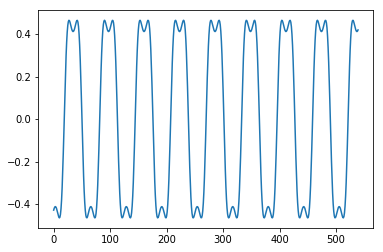

In [13]:
SIZE = 200

data = np.arange(-27, 27, 0.1)
data = np.sin(data)
data = np.cos(data)* np.tanh(data)

def make_x_y(data, size=500):
    N = data.shape[0]
    
    data_x = np.zeros((N-size*2, size))
    data_y = np.zeros((N-size*2, size))
    for i, idx in enumerate(range(0, N-size*2)):
        x = data[idx: idx+size]
        y = data[idx+size: idx+size*2]
        
        data_x[idx, :x.shape[0]] = x
        data_y[idx, :y.shape[0]] = y
        
    data_x = np.asarray(data_x)
    data_y = np.asarray(data_y)
    
    data_x = data_x.reshape(-1, size, 1)
    data_y = data_y.reshape(-1, size, 1)
    
    # Shuffle
    permu = np.random.permutation(data_x.shape[0])
    data_x = data_x[permu]
    data_y = data_y[permu]
    return data_x, data_y


x, y = make_x_y(data, size=SIZE)
print('x:', x.shape)
print('y:', y.shape)

plot(data)

### Visualize training data 

x값과 y값을 한번에 합쳐서 보여줍니다.<br> 
대충 중간에 선이 있다고 생각하면 됩니다. 왼쪽은 x값 오른쪽은 y값


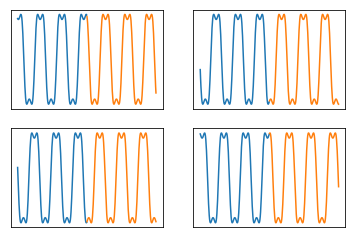

In [16]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            
            r = np.random.randint(data_x.shape[0])
            sample_x = data_x[r]
            sample_y = data_y[r]
            
            
            sample_x = sample_x.reshape(sample_x.shape[0])
            sample_y = sample_y.reshape(sample_y.shape[0])
            tick_x = range(0, SIZE)
            tick_y = range(SIZE, SIZE*2)
            
            sp.plot(tick_x, sample_x)
            sp.plot(tick_y, sample_y)

visualize(x, y)

## Model

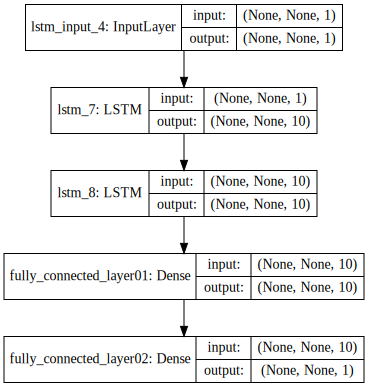

In [22]:
def create_model(lstm_out=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(batch_input_shape=(None, None, 1), output_dim=lstm_out, return_sequences=True))
    model.add(LSTM(batch_input_shape=(None, None, 1), output_dim=lstm_out, return_sequences=True))
    model.add(Dense(output_dim=10, name='fully_connected_layer01'))
    model.add(Dense(output_dim=1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [48]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, SIZE))
    y_pred = y_pred.reshape((-1, SIZE))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


# Grid Search 
params = dict(lstm_out=[1, 10, 20, 30, 40, 300], 
              optimizer=['adam'], 
              nb_epoch=[10])

classifier = KerasClassifier(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer)
grid_result = grid.fit(x, y)

error:0.1515784634639441, score:-0.043875617523980205
error:0.1512648480533925, score:-0.0048200634615640945
error:0.15140825575702951, score:-0.0026962455203625012
error:0.15135086700204825, score:-0.012921752482579523
error:0.15111832279098075, score:-0.009901143899094769
error:0.1514933596104868, score:-0.014828480273632398
error:0.17021333725310658, score:-0.17220842905673867
error:0.17041399076466607, score:-0.13202372671837537
error:0.15559272478035463, score:-0.030407755425855644
error:0.15563689969329195, score:-0.041606198305763675
error:0.16666604253523715, score:-0.11380422900985808
error:0.16670826424647, score:-0.11675056180211052
error:0.16545474329385584, score:-0.13943741334486384
error:0.1654992897419204, score:-0.09937641799383426
error:0.15860869777675343, score:-0.050380938426740386
error:0.15866229170041646, score:-0.06185375574963273
error:0.1678767930037949, score:-0.12189549326286371
error:0.1677598545712714, score:-0.12379498813163767
error:0.153043961273174, s

In [51]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

Best: {'lstm_out': 10, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.01888807,	STD Score:0.018005,	Params: {'lstm_out': 1, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.105414,	STD Score:0.058392,	Params: {'lstm_out': 10, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.1037761,	STD Score:0.038626,	Params: {'lstm_out': 20, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.02353947,	STD Score:0.022095,	Params: {'lstm_out': 30, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.09672495,	STD Score:0.030445,	Params: {'lstm_out': 40, 'nb_epoch': 10, 'optimizer': 'adam'}
Mean Score:0.03073086,	STD Score:0.020759,	Params: {'lstm_out': 300, 'nb_epoch': 10, 'optimizer': 'adam'}


## Train

In [52]:
params = dict(lstm_out=10,
              optimizer='adam')

model = create_model(**params)
model.fit(x, y, verbose=2, nb_epoch=30)

Epoch 1/30
10s - loss: 0.1478 - mean_squared_error: 0.1478
Epoch 2/30
2s - loss: 0.1149 - mean_squared_error: 0.1149
Epoch 3/30
2s - loss: 0.0837 - mean_squared_error: 0.0837
Epoch 4/30
2s - loss: 0.0567 - mean_squared_error: 0.0567
Epoch 5/30
2s - loss: 0.0367 - mean_squared_error: 0.0367
Epoch 6/30
2s - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 7/30
2s - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 8/30
2s - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 9/30
2s - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 10/30
2s - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 11/30
2s - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 12/30
2s - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 13/30
2s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 14/30
2s - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 15/30
2s - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 16/30
2s - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 17/30
2s - loss: 0.0159 - mean_squared_error: 0.0159
Epoch

error:0.014080679960290327, score:0.9062062711349964
Mean Squared Error: 0.906206271135


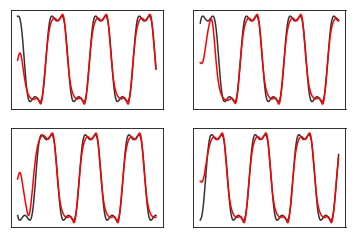

In [53]:
def visualize_prediction(data_x, data_y):
    data_p = model.predict(data_x)
    data_x = data_x.reshape((-1, SIZE))
    data_y = data_y.reshape((-1, SIZE))
    data_p = data_p.reshape((-1, SIZE))
    
    print('Mean Squared Error:', accuracy(data_y, data_p))
    
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
        
            idx = np.random.randint(data_x.shape[0])
            
            sp.plot(data_y[idx], color='#333333')
            sp.plot(data_p[idx], color='red')


visualize_prediction(x, y)